In [2]:

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

import predictive_plots,predictive_clustering,utils

In [3]:
predictive_processing_dataset = pd.read_excel("All_Features_dataset.xlsx")
scales = pd.read_excel("filled_scales_BEBRASK_RETOS.xlsx")


In [4]:
scales.drop(["SUBJECT_CODE"],axis=1,inplace=True)

common_values = scales['EPRIME_CODE'].unique()
predictive_processing_dataset = predictive_processing_dataset[predictive_processing_dataset['Subject'].isin(common_values)]


#### Cluster for PANAS on important features for related metrics

related metrics: PA, NA, ERQ_CR, UPPSP_PSV, TEPS_CF, SHS, RRQ_Ref, LOT_R

In [5]:
significant_features = ['Final_Value_Match_Negative', 'Final_Value_No_Match_Negative', 'Intercept_Match_Negative', 'Mean_Rating0_No_Match_Happy', 'Final_Value_No_Match_Happy', 'Intercept_No_Match_Happy', 'Dif_Negative', 'Dif_Happy', 'Mean_Rating0_No_Match_Negative', 'Trend_No_Match_Negative', 'Intercept_Match_Happy', 'Mean_Rating0_Match_Negative', 'Trend_No_Match_Happy', 'Mean_Rating0_Match_Happy']
metrics_columns = scales.drop("EPRIME_CODE",axis=1).columns.values


In [6]:
predictive_processing_dataset[significant_features].corr()

,Final_Value_Match_Negative,Final_Value_No_Match_Negative,Intercept_Match_Negative,Mean_Rating0_No_Match_Happy,Final_Value_No_Match_Happy,Intercept_No_Match_Happy,Dif_Negative,Dif_Happy,Mean_Rating0_No_Match_Negative,Trend_No_Match_Negative,Intercept_Match_Happy,Mean_Rating0_Match_Negative,Trend_No_Match_Happy,Mean_Rating0_Match_Happy
Final_Value_Match_Negative,1.000000,0.311074,-0.125418,0.019982,-0.191609,0.222450,0.384582,0.262601,0.418201,0.072105,0.267691,0.726270,-0.252465,0.365318
Final_Value_No_Match_Negative,0.311074,1.000000,-0.003669,0.134231,0.046320,0.106727,-0.249312,0.099158,0.588706,0.796738,0.144150,0.250414,-0.050025,0.236515
Intercept_Match_Negative,-0.125418,-0.003669,1.000000,-0.098330,-0.170837,0.064282,0.472244,0.240316,0.154783,-0.120254,0.298587,0.590894,-0.132340,0.243580
Mean_Rating0_No_Match_Happy,0.019982,0.134231,-0.098330,1.000000,0.589060,0.541202,-0.284851,-0.665546,0.269690,-0.035596,-0.141430,-0.051882,-0.071521,-0.108395
Final_Value_No_Match_Happy,-0.191609,0.046320,-0.170837,0.589060,1.000000,-0.360715,-0.271254,-0.472754,-0.011148,0.065625,-0.299718,-0.274180,0.763889,-0.171350
Intercept_No_Match_Happy,0.222450,0.106727,0.064282,0.541202,-0.360715,1.000000,-0.046502,-0.276211,0.322869,-0.109373,0.148650,0.225430,-0.877446,0.053199
Dif_Negative,0.384582,-0.249312,0.472244,-0.284851,-0.271254,-0.046502,1.000000,0.418804,-0.401008,-0.008569,0.324891,0.639939,-0.107330,0.336189
Dif_Happy,0.262601,0.099158,0.240316,-0.665546,-0.472754,-0.276211,0.418804,1.000000,-0.034376,0.148344,0.620241,0.380049,-0.052018,0.814101
Mean_Rating0_No_Match_Negative,0.418201,0.588706,0.154783,0.269690,-0.011148,0.322869,-0.401008,-0.034376,1.000000,-0.019459,0.127997,0.447315,-0.229136,0.164052
Trend_No_Match_Negative,0.072105,0.796738,-0.120254,-0.035596,0.065625,-0.109373,-0.008569,0.148344,-0.019459,1.000000,0.082602,-0.024688,0.109429,0.169890


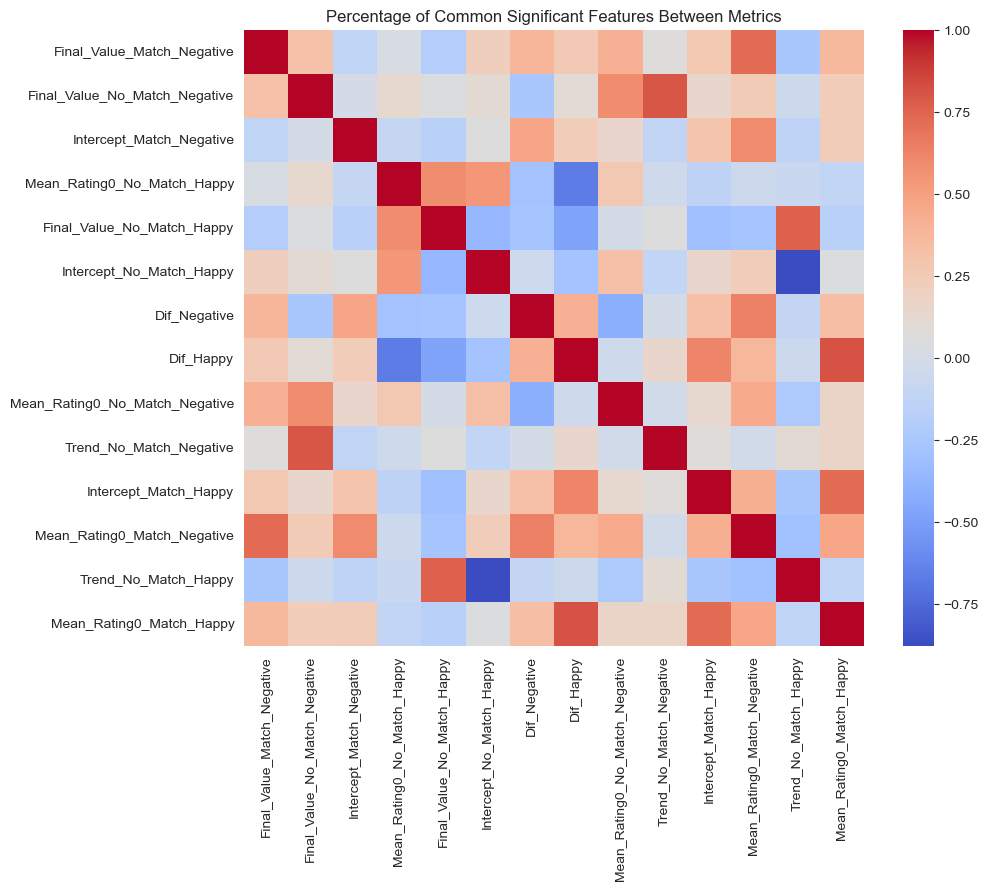

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(predictive_processing_dataset[significant_features].corr(), cmap='coolwarm', fmt=".2f")
plt.title('Percentage of Common Significant Features Between Metrics')
plt.show()


#### Dimension Reduction: PCA

In [8]:
scaler = StandardScaler()
scaler.fit(predictive_processing_dataset[significant_features])
normalized_data = scaler.transform(predictive_processing_dataset[significant_features])


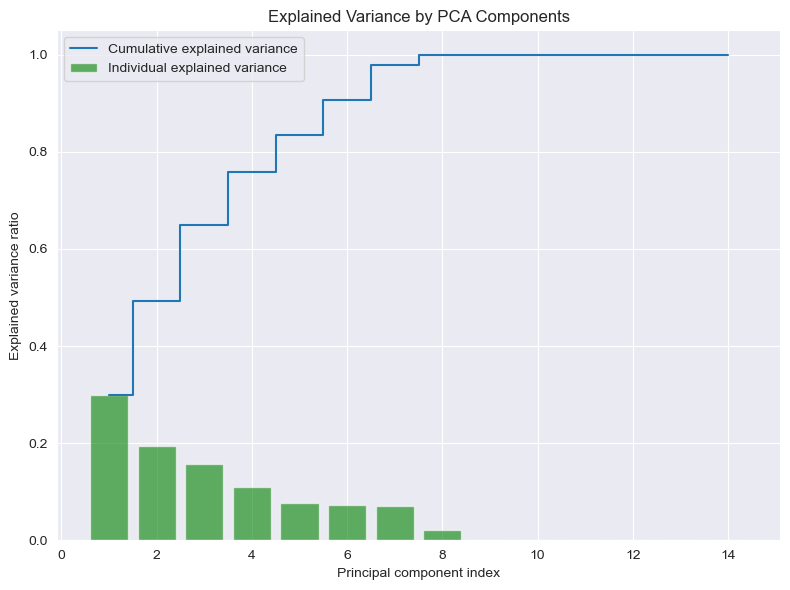

In [9]:
pca = PCA()
pca.fit(normalized_data)
explained_variance = pca.explained_variance_ratio_

# Step 4: Plot the explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='g',
        label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

5 seems like a good dimension, with enough variance explained

In [10]:
pca = PCA(n_components=5)
principal_components = pca.fit_transform(normalized_data)
pca.explained_variance_ratio_

array([0.29930627, 0.19330562, 0.15684652, 0.10920781, 0.076061  ])

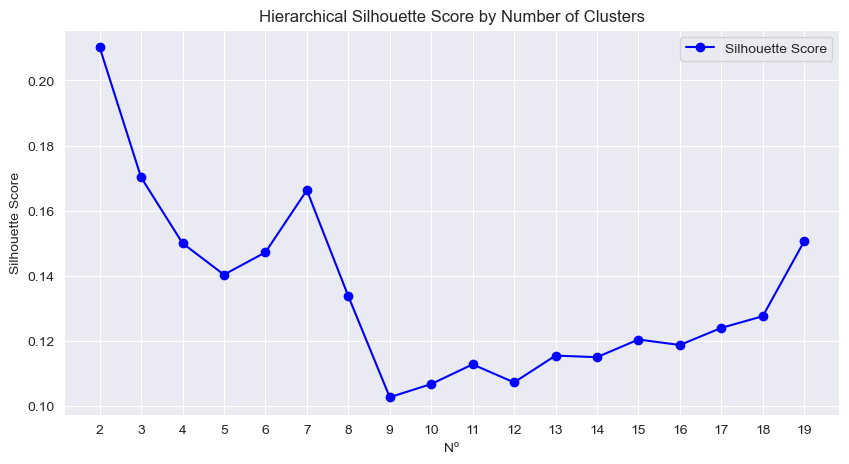

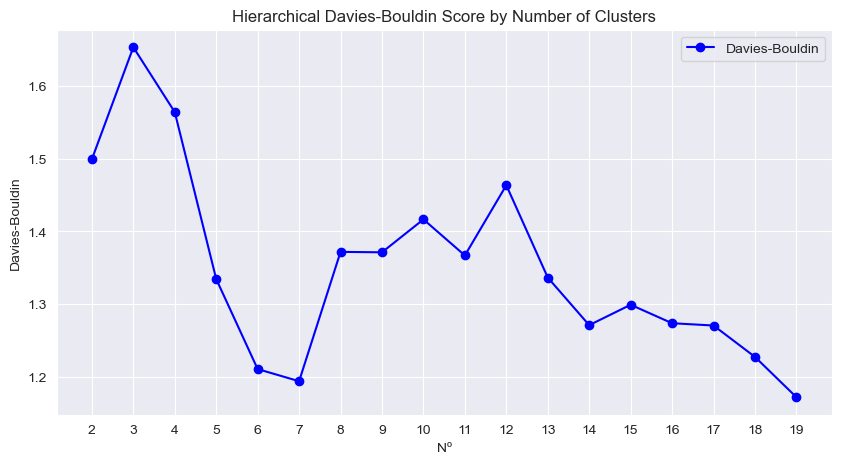

In [11]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(principal_components,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(principal_components, data_clusters))
    db.append(davies_bouldin_score(principal_components, data_clusters))
    
    
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)

7 clusters seems as the best bet

In [12]:
PANAS = ["PA", "NA."]
ERQ = ["ERQ_CR", "ERQ_ES"]
UPPSP = ["UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV"]
BIS_BAS = ["BIS", "BAS_D", "BAS_RR", "BAS_FS"]
TEPS = ["TEPS_AF", "TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum", "RRQ_Ref"]
ASI3 = ["ASI_P", "ASI_C", "ASI_S"]
SPQ = ["SPQ", "SPQ_IR"]
MSSB = ["MSSB_POS", "MSSB_NEG", "MSSB_DES"]

list_metrics = [PANAS, ERQ, UPPSP, BIS_BAS, TEPS, SHS, FS, LOTR, RRQ, ASI3, SPQ, MSSB]

In [13]:
predictive_processing_dataset[significant_features]

,Final_Value_Match_Negative,Final_Value_No_Match_Negative,Intercept_Match_Negative,Mean_Rating0_No_Match_Happy,Final_Value_No_Match_Happy,Intercept_No_Match_Happy,Dif_Negative,Dif_Happy,Mean_Rating0_No_Match_Negative,Trend_No_Match_Negative,Intercept_Match_Happy,Mean_Rating0_Match_Negative,Trend_No_Match_Happy,Mean_Rating0_Match_Happy
0,3.522222,1.833333,3.222222,1.500000,0.428571,3.000000,1.305556,2.388889,2.083333,-0.100000,4.222222,3.388889,-4.285714e-01,3.888889
1,2.800000,2.547619,2.875000,1.333333,1.047619,1.733333,0.750000,2.000000,2.083333,0.185714,3.833333,2.833333,-1.142857e-01,3.333333
2,2.888889,1.261905,2.513889,1.166667,1.380952,0.866667,1.388889,2.388889,1.333333,-0.028571,3.222222,2.722222,8.571429e-02,3.555556
3,3.444444,1.428571,2.694444,1.000000,1.000000,1.000000,1.111111,2.222222,2.000000,-0.228571,2.472222,3.111111,-2.327660e-17,3.222222
4,3.044444,1.357143,1.694444,1.166667,1.095238,1.266667,0.944444,2.500000,1.500000,-0.057143,4.250000,2.444444,-2.857143e-02,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.077778,1.833333,2.527778,1.500000,1.857143,1.000000,0.944444,1.611111,1.333333,0.200000,2.361111,2.277778,1.428571e-01,3.111111
146,2.611111,1.547619,2.986111,1.166667,1.523810,0.666667,1.194444,2.500000,1.583333,-0.014286,3.916667,2.777778,1.428571e-01,3.666667
147,2.922222,2.119048,3.222222,1.000000,1.000000,1.000000,0.972222,2.555556,2.083333,0.014286,4.555556,3.055556,-2.327660e-17,3.555556
148,2.344444,1.642857,3.694444,1.333333,1.761905,0.733333,1.194444,2.444444,1.750000,-0.042857,3.361111,2.944444,1.714286e-01,3.777778


In [28]:
data_clusters = predictive_clustering.clustering(principal_components,AgglomerativeClustering,{'n_clusters':7,'linkage':"complete"},fit=True)
df_cluster = pd.concat([predictive_processing_dataset["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]
name_output = f"PCA_Important_Features.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output)
    
    
    
output_name = f'test_distribution_7_clusters.xlsx'
utils.export_clusters_df(df_cluster.copy(),output_name)


In [38]:
Positive = ["Mean_Rating0_No_Match_Happy"]
Negative = ["Final_Value_Match_Negative"]

list_emotions = [Positive,Negative]

name_output = f"test_distribution_7_clusters_tasks.docx"
new_data = pd.merge(predictive_processing_dataset[significant_features + ["Subject"]].copy(), df_cluster.copy(), right_on='Subject', left_on='Subject')

In [40]:
new_data.drop("Subject")

,Final_Value_Match_Negative,Final_Value_No_Match_Negative,Intercept_Match_Negative,Mean_Rating0_No_Match_Happy,Final_Value_No_Match_Happy,Intercept_No_Match_Happy,Dif_Negative,Dif_Happy,Mean_Rating0_No_Match_Negative,Trend_No_Match_Negative,Intercept_Match_Happy,Mean_Rating0_Match_Negative,Trend_No_Match_Happy,Mean_Rating0_Match_Happy,Subject,clusters
0,3.522222,1.833333,3.222222,1.500000,0.428571,3.000000,1.305556,2.388889,2.083333,-0.100000,4.222222,3.388889,-4.285714e-01,3.888889,PREDWELL_RETOS-1-1,3.0
1,2.800000,2.547619,2.875000,1.333333,1.047619,1.733333,0.750000,2.000000,2.083333,0.185714,3.833333,2.833333,-1.142857e-01,3.333333,PREDWELL_RETOS-10-1,0.0
2,2.888889,1.261905,2.513889,1.166667,1.380952,0.866667,1.388889,2.388889,1.333333,-0.028571,3.222222,2.722222,8.571429e-02,3.555556,PREDWELL_RETOS-101-1,0.0
3,3.444444,1.428571,2.694444,1.000000,1.000000,1.000000,1.111111,2.222222,2.000000,-0.228571,2.472222,3.111111,-2.327660e-17,3.222222,PREDWELL_RETOS-102-1,0.0
4,3.044444,1.357143,1.694444,1.166667,1.095238,1.266667,0.944444,2.500000,1.500000,-0.057143,4.250000,2.444444,-2.857143e-02,3.666667,PREDWELL_RETOS-103-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2.077778,1.833333,2.527778,1.500000,1.857143,1.000000,0.944444,1.611111,1.333333,0.200000,2.361111,2.277778,1.428571e-01,3.111111,PREDWELL_RETOS-1124-1,0.0
145,2.611111,1.547619,2.986111,1.166667,1.523810,0.666667,1.194444,2.500000,1.583333,-0.014286,3.916667,2.777778,1.428571e-01,3.666667,PREDWELL_RETOS-1125-1,0.0
146,2.922222,2.119048,3.222222,1.000000,1.000000,1.000000,0.972222,2.555556,2.083333,0.014286,4.555556,3.055556,-2.327660e-17,3.555556,PREDWELL_RETOS-1126-1,0.0
147,2.344444,1.642857,3.694444,1.333333,1.761905,0.733333,1.194444,2.444444,1.750000,-0.042857,3.361111,2.944444,1.714286e-01,3.777778,PREDWELL_RETOS-1127-1,1.0


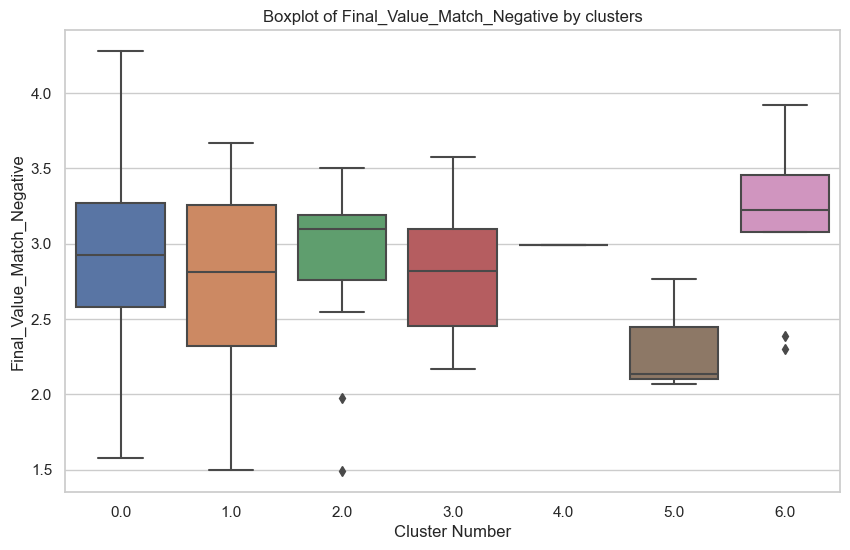

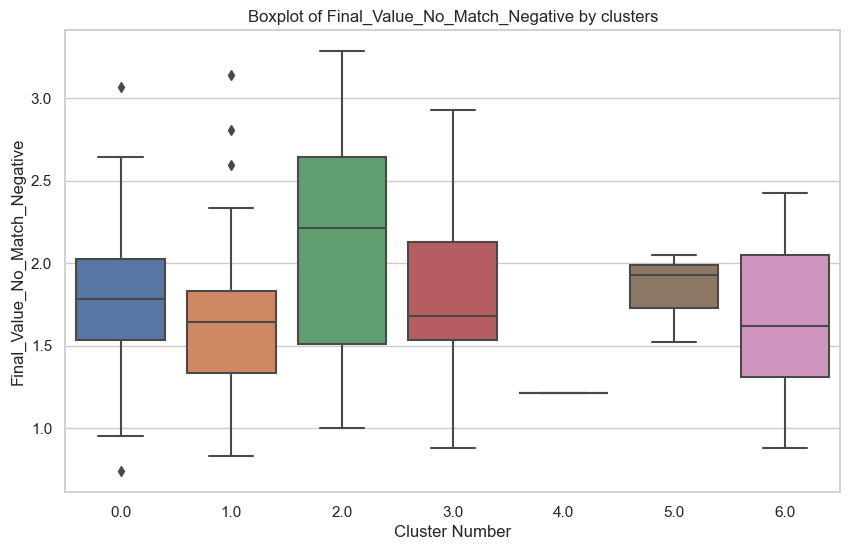

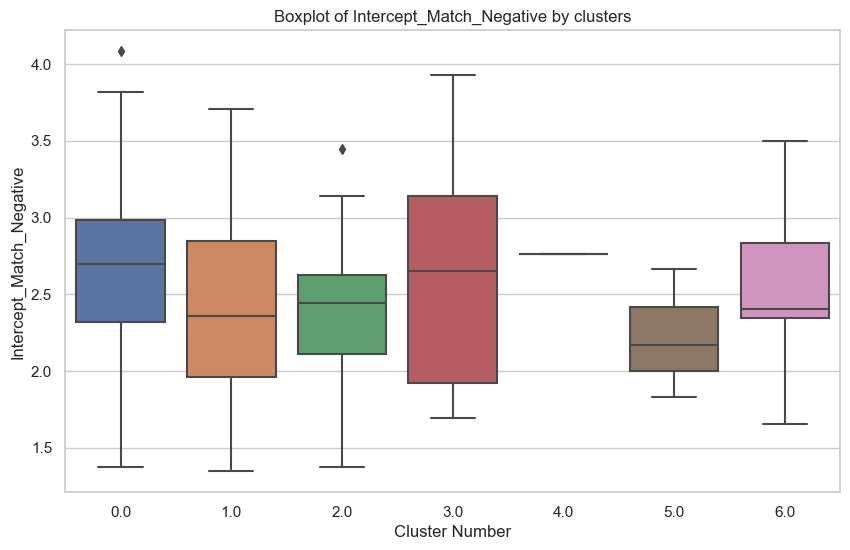

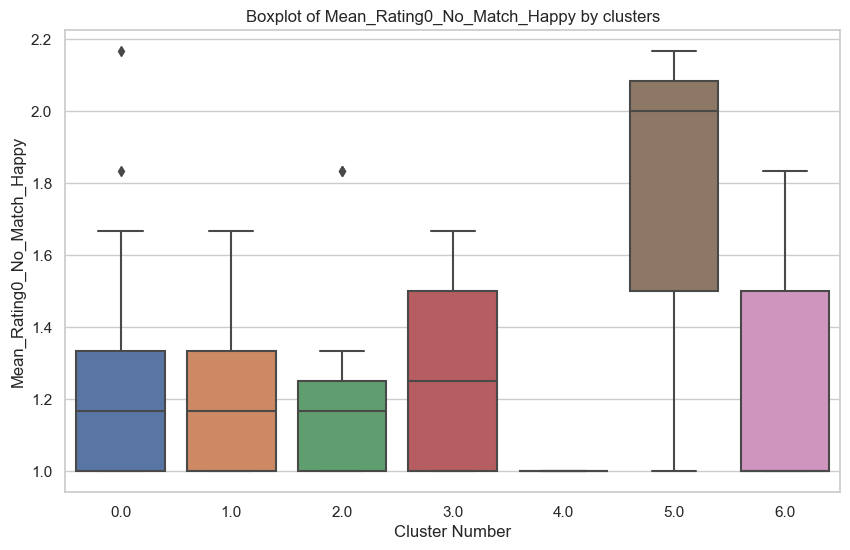

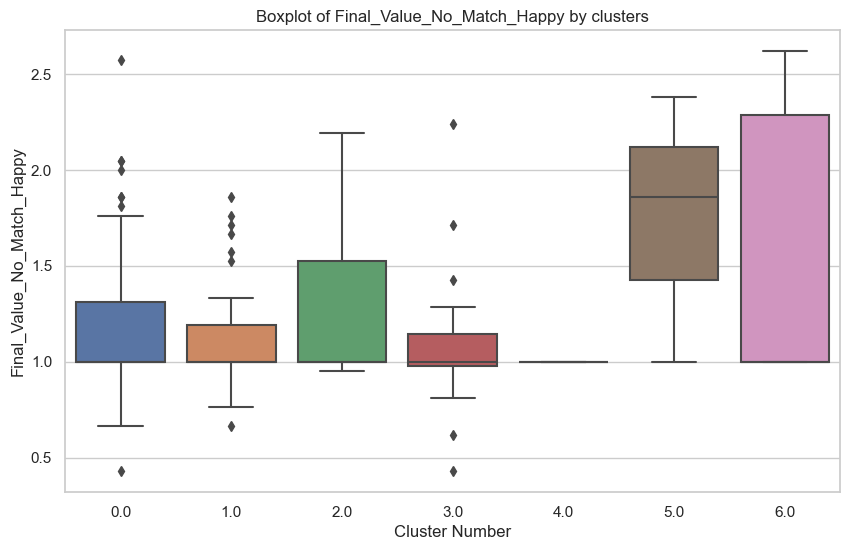

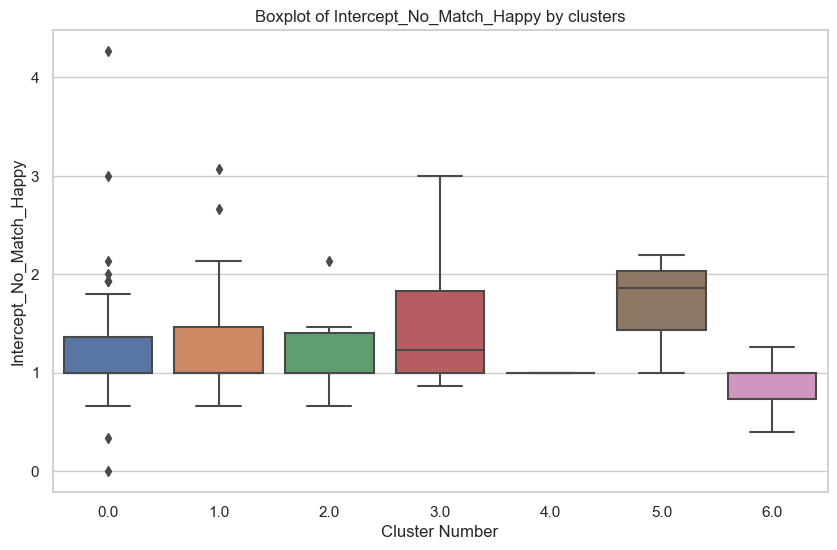

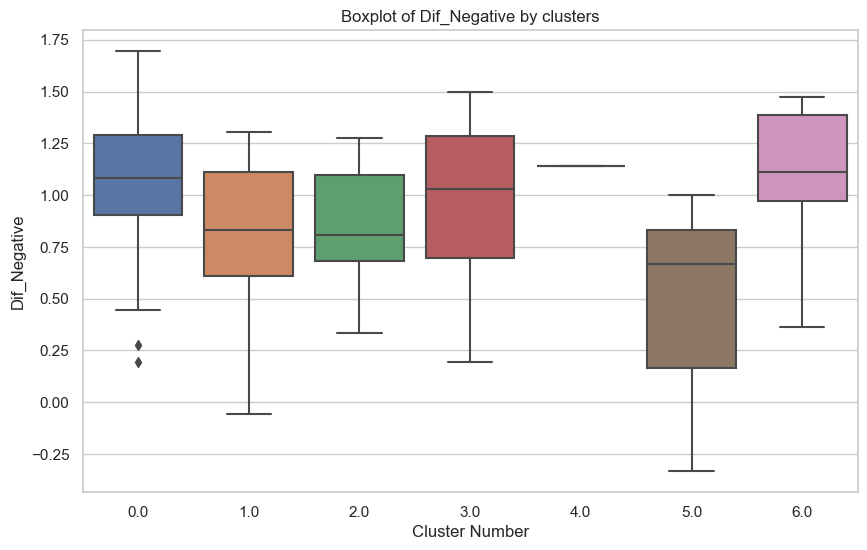

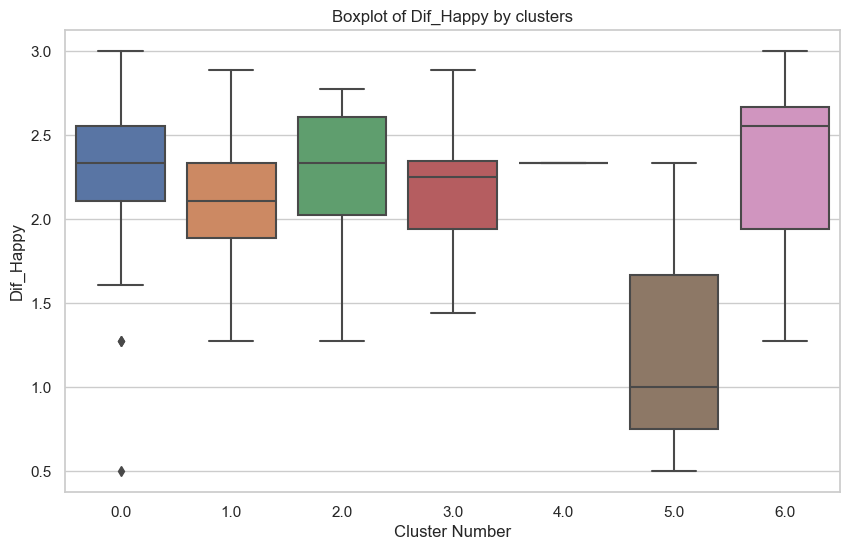

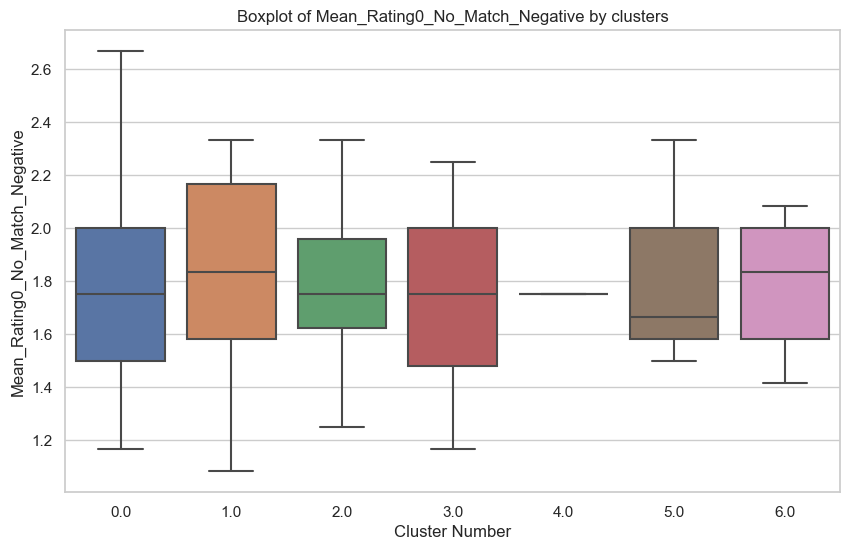

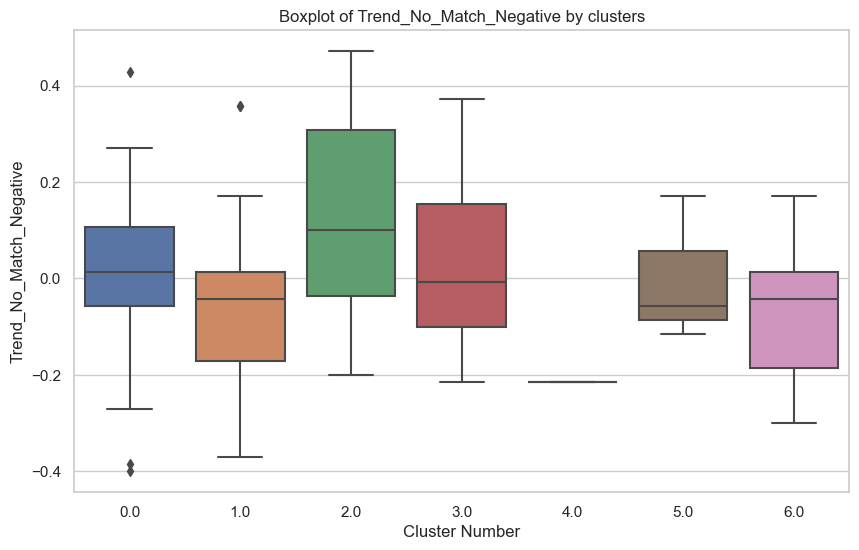

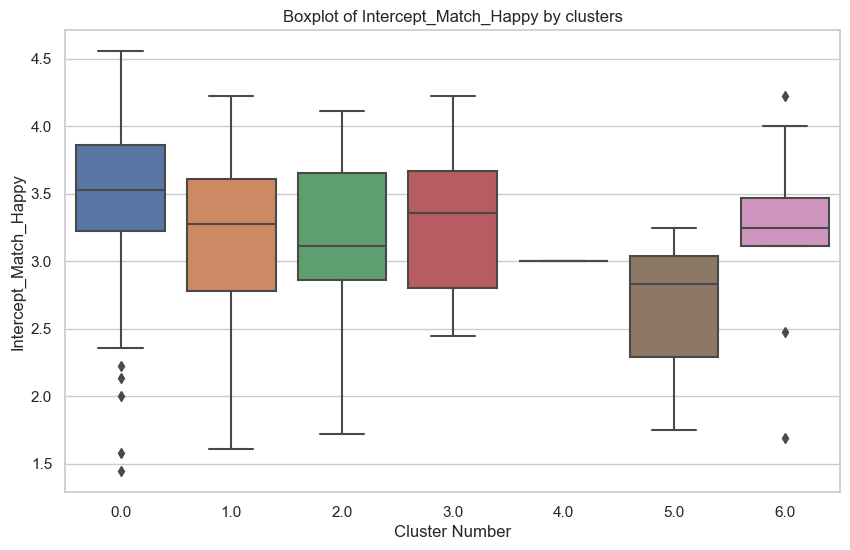

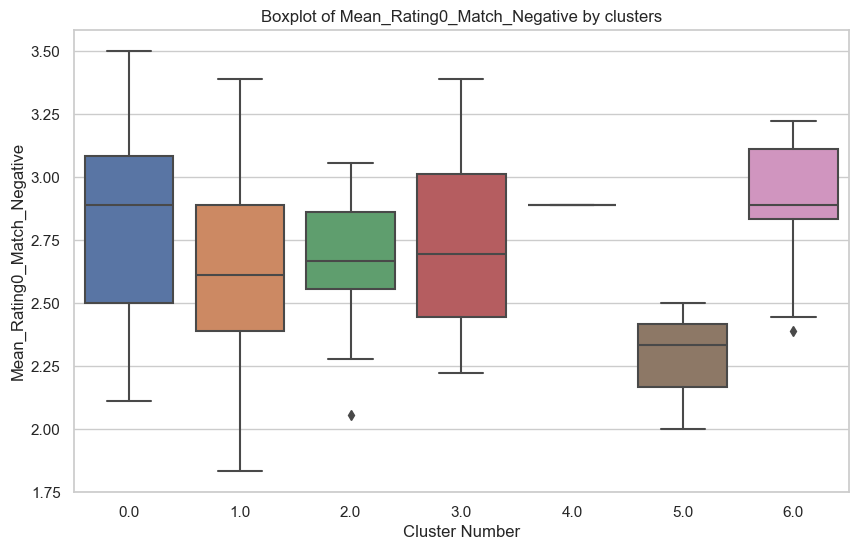

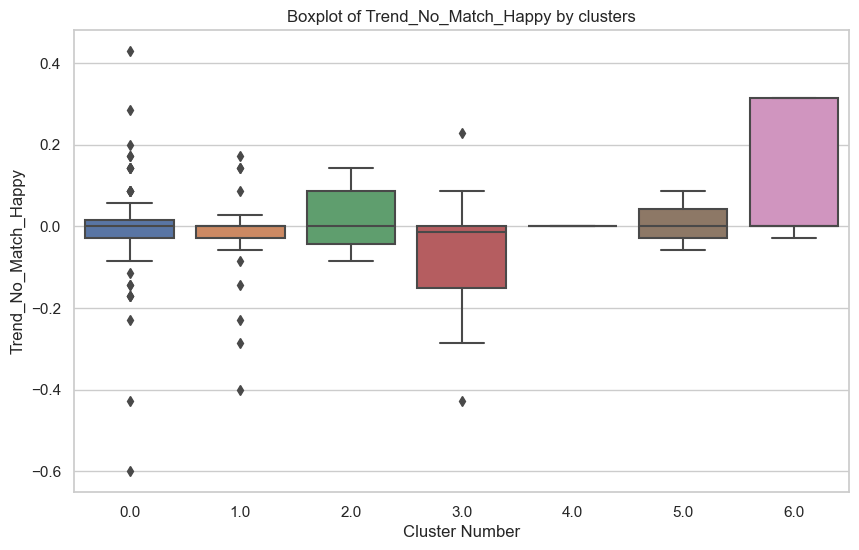

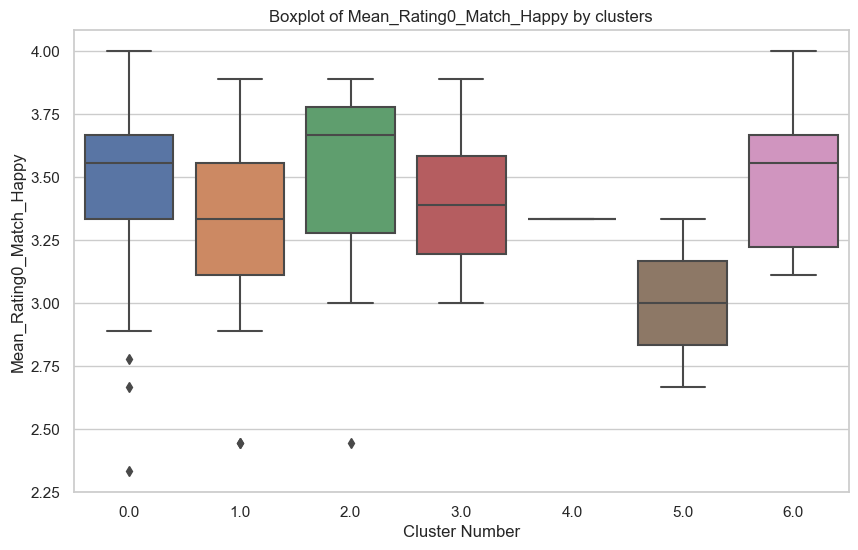

In [41]:
new_data = pd.merge(predictive_processing_dataset[significant_features + ["Subject"]].copy(), df_cluster.copy(), right_on='Subject', left_on='Subject')

cluster_column = 'clusters'  # Change this if the actual name differs
features = new_data.columns.drop([cluster_column,"Subject"])  # This excludes the cluster column from the features list

# Plotting
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cluster_column, y=feature, data=new_data)
    plt.title(f'Boxplot of {feature} by {cluster_column}')
    plt.xlabel('Cluster Number')
    plt.ylabel(feature)
    plt.show()

#### Without PCA

In [77]:
normalized_data

array([[ 1.19251515],
       [-0.14022305],
       [ 0.02380627],
       [ 1.0489895 ],
       [ 0.31085757],
       [-0.44777802],
       [-1.04238429],
       [ 0.45438323],
       [-0.24274137],
       [-2.53915182],
       [ 0.31085757],
       [-0.55029634],
       [ 1.52057379],
       [-0.16072671],
       [ 1.06949317],
       [-1.51396858],
       [ 0.84395286],
       [ 0.7004272 ],
       [-0.01720106],
       [ 0.24934658],
       [ 0.90546385],
       [ 0.7004272 ],
       [-1.30893194],
       [-1.71900523],
       [-0.73482932],
       [ 0.45438323],
       [-1.02188063],
       [-1.65749424],
       [-0.93986597],
       [-0.83734765],
       [ 0.57740521],
       [ 0.57740521],
       [-0.89885864],
       [ 0.16733192],
       [-0.75533299],
       [-1.37044293],
       [-0.73482932],
       [ 1.02848584],
       [-1.49346492],
       [ 0.4133759 ],
       [ 1.41805547],
       [-1.53447225],
       [-0.65281467],
       [-0.61180734],
       [-0.18123038],
       [ 0

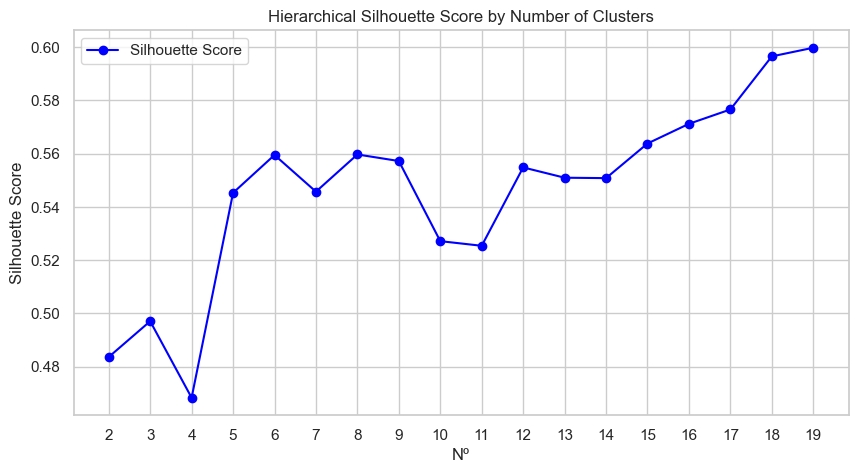

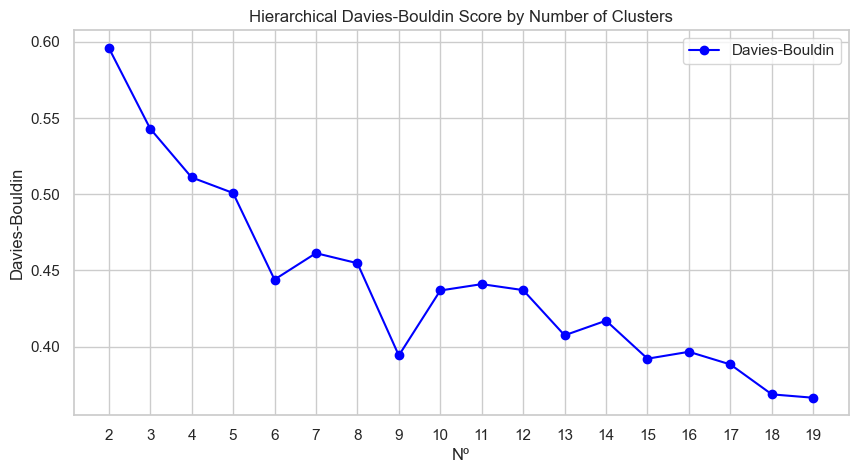

In [78]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(normalized_data, data_clusters))
    db.append(davies_bouldin_score(normalized_data, data_clusters))
    
    
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)

In [80]:
data_clusters = predictive_clustering.clustering(principal_components,AgglomerativeClustering,{'n_clusters':6,'linkage':"complete"},fit=True)
df_cluster = pd.concat([predictive_processing_dataset["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]
name_output = f"Normalized_Data_6_clusters.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output)
    
    
    
output_name = f'test_distribution_3_clusters.xlsx'
utils.export_clusters_df(df_cluster.copy(),output_name)

### Top Features for PA and NA

In [81]:
significant_features = ["Mean_Rating0_No_Match_Negative","Mean_Rating0_Match_Negative","Final_Value_No_Match_Negative","Intercept_No_Match_Happy","Trend_No_Match_Happy","Intercept_Match_Happy"]
predictive_processing_dataset[significant_features].corr()

,Mean_Rating0_No_Match_Negative,Mean_Rating0_Match_Negative,Final_Value_No_Match_Negative,Intercept_No_Match_Happy,Trend_No_Match_Happy,Intercept_Match_Happy
Mean_Rating0_No_Match_Negative,1.000000,0.447315,0.588706,0.322869,-0.229136,0.127997
Mean_Rating0_Match_Negative,0.447315,1.000000,0.250414,0.225430,-0.296993,0.424563
Final_Value_No_Match_Negative,0.588706,0.250414,1.000000,0.106727,-0.050025,0.144150
Intercept_No_Match_Happy,0.322869,0.225430,0.106727,1.000000,-0.877446,0.148650
Trend_No_Match_Happy,-0.229136,-0.296993,-0.050025,-0.877446,1.000000,-0.257001
Intercept_Match_Happy,0.127997,0.424563,0.144150,0.148650,-0.257001,1.000000


In [82]:
scaler = StandardScaler()
scaler.fit(predictive_processing_dataset[significant_features])
normalized_data = scaler.transform(predictive_processing_dataset[significant_features])


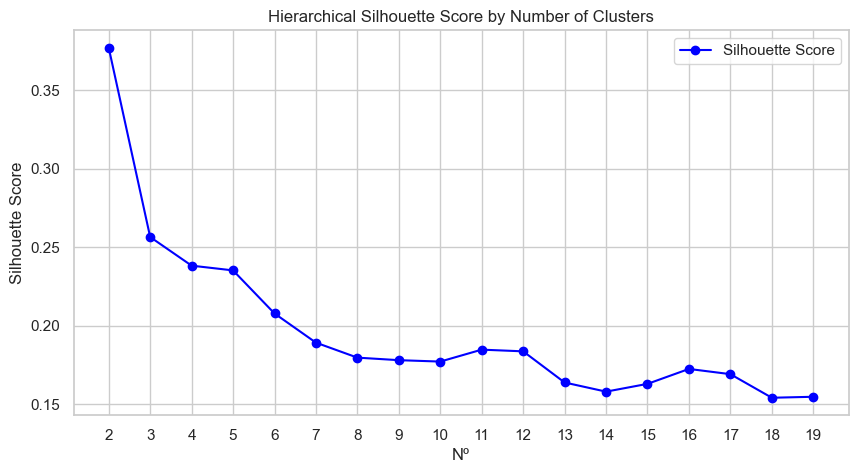

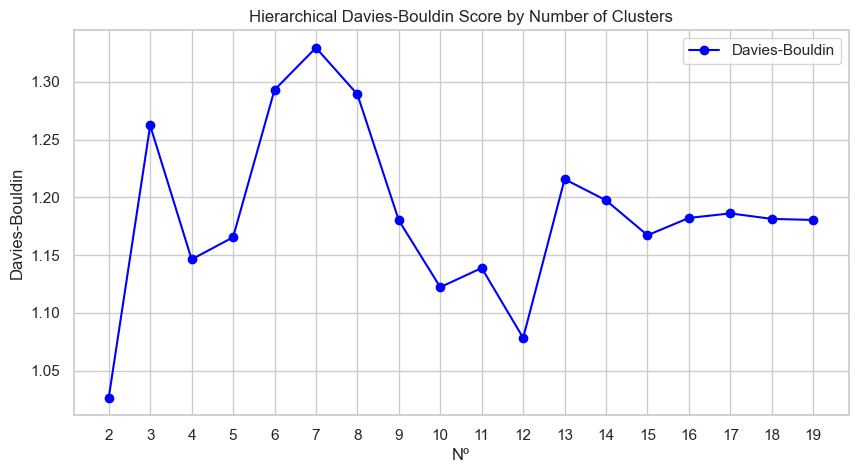

In [83]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(normalized_data, data_clusters))
    db.append(davies_bouldin_score(normalized_data, data_clusters))
    
    
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)

In [55]:
PANAS = ["PA", "NA."]


list_metrics = [PANAS]

In [57]:
data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':5,'linkage':"complete"},fit=True)
df_cluster = pd.concat([predictive_processing_dataset["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]
name_output = f"PANAS.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output)
    
    
    
output_name = f'test_distribution_5_clusters.xlsx'
utils.export_clusters_df(df_cluster.copy(),output_name)

#### Features that cover the most

In [84]:
significant_features = ["Mean_Rating0_No_Match_Negative","Dif_Negative","Final_Value_Match_Negative","Dif_Happy"]


In [85]:
scaler = StandardScaler()
scaler.fit(predictive_processing_dataset[significant_features])
normalized_data = scaler.transform(predictive_processing_dataset[significant_features])


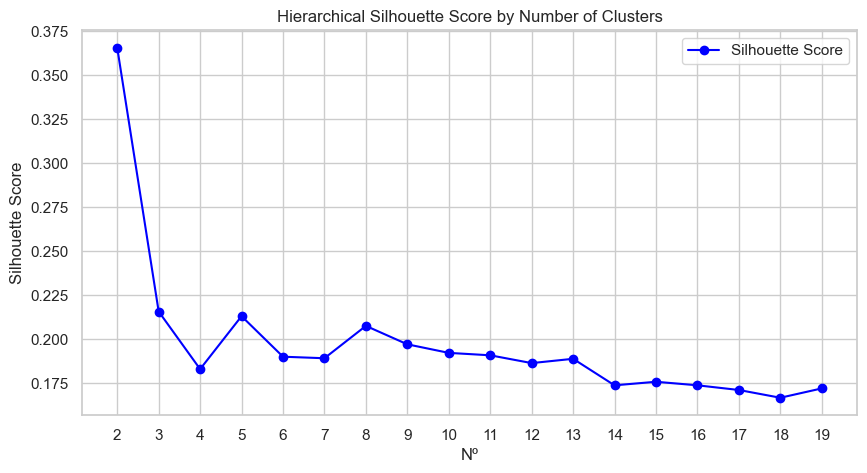

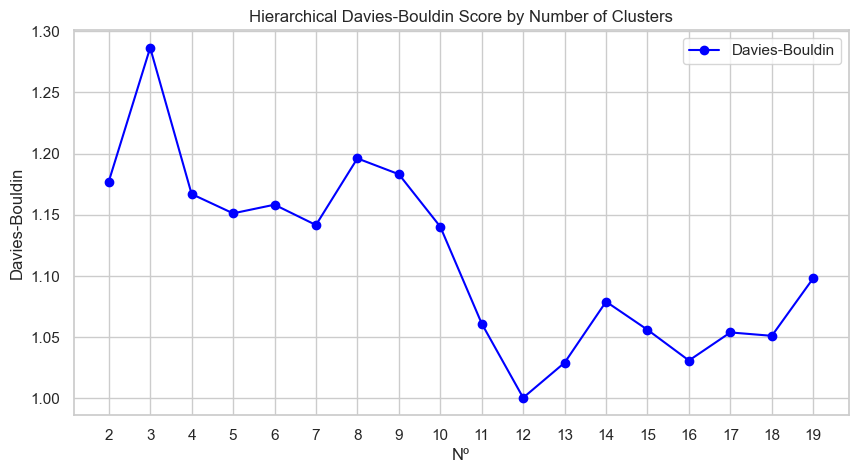

In [86]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(normalized_data, data_clusters))
    db.append(davies_bouldin_score(normalized_data, data_clusters))
    
    
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)

In [62]:
PANAS = ["PA", "NA."]
ERQ = ["ERQ_CR", "ERQ_ES"]
UPPSP = ["UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV"]
BIS_BAS = ["BIS", "BAS_D", "BAS_RR", "BAS_FS"]
TEPS = ["TEPS_AF", "TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum", "RRQ_Ref"]
ASI3 = ["ASI_P", "ASI_C", "ASI_S"]
SPQ = ["SPQ", "SPQ_IR"]
MSSB = ["MSSB_POS", "MSSB_NEG", "MSSB_DES"]

list_metrics = [PANAS, ERQ, UPPSP, BIS_BAS, TEPS, SHS, FS, LOTR, RRQ, ASI3, SPQ, MSSB]

In [65]:
data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':4,'linkage':"complete"},fit=True)
df_cluster = pd.concat([predictive_processing_dataset["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]
name_output = f"Cover_Metrics.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output)
    
    
    
output_name = f'test_distribution_4_clusters.xlsx'
utils.export_clusters_df(df_cluster.copy(),output_name)

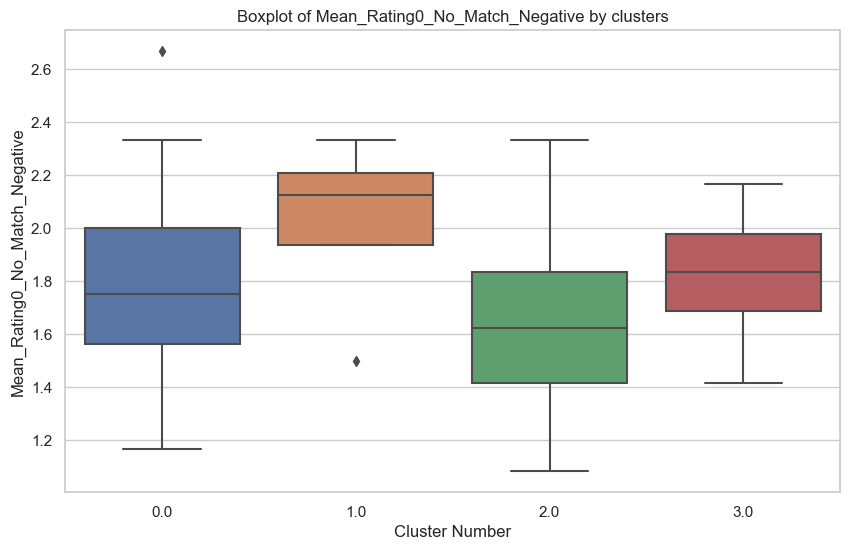

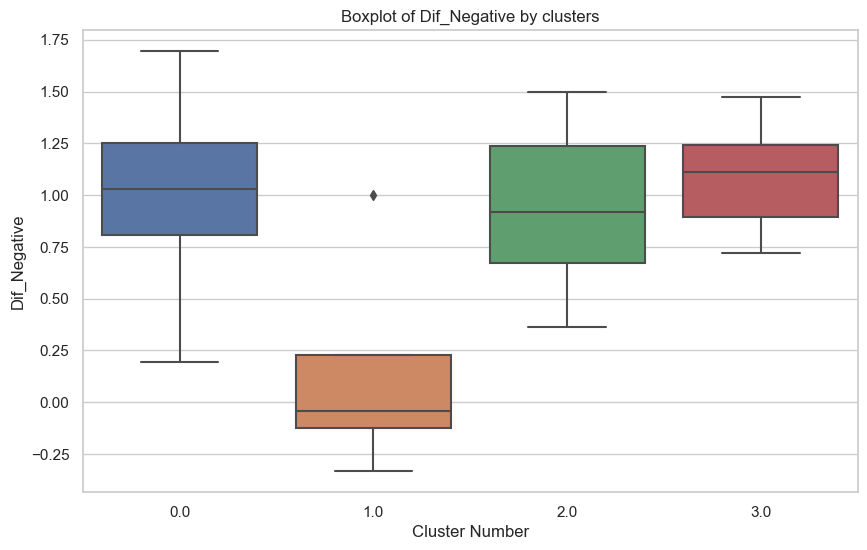

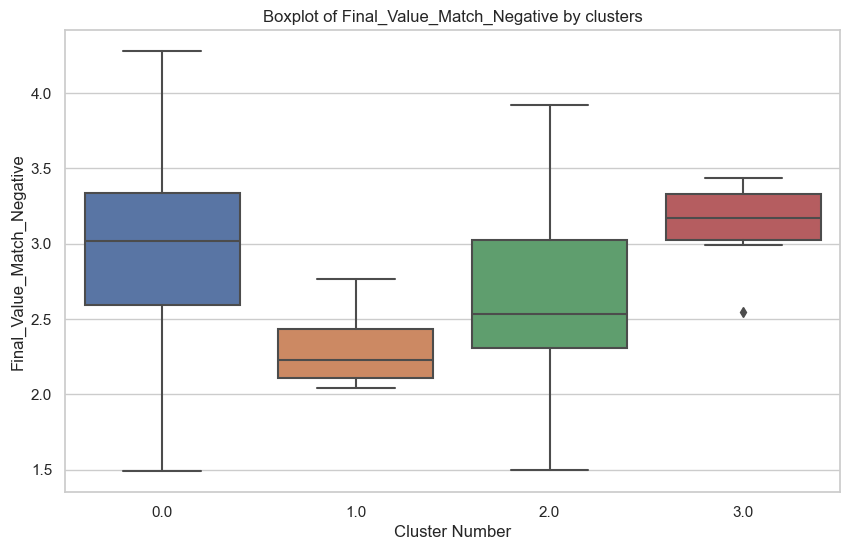

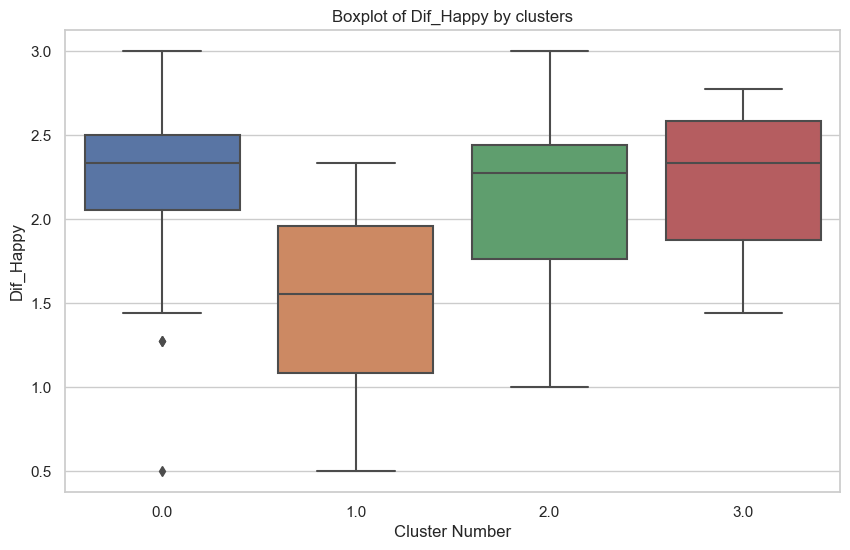

In [66]:
new_data = pd.merge(predictive_processing_dataset[significant_features + ["Subject"]].copy(), df_cluster.copy(), right_on='Subject', left_on='Subject')

cluster_column = 'clusters'  # Change this if the actual name differs
features = new_data.columns.drop([cluster_column,"Subject"])  # This excludes the cluster column from the features list

# Plotting
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cluster_column, y=feature, data=new_data)
    plt.title(f'Boxplot of {feature} by {cluster_column}')
    plt.xlabel('Cluster Number')
    plt.ylabel(feature)
    plt.show()

#### Feature with most significant p-values

In [87]:
significant_features = ["Dif_Happy"]


In [88]:
scaler = StandardScaler()
scaler.fit(predictive_processing_dataset[significant_features])
normalized_data = scaler.transform(predictive_processing_dataset[significant_features])


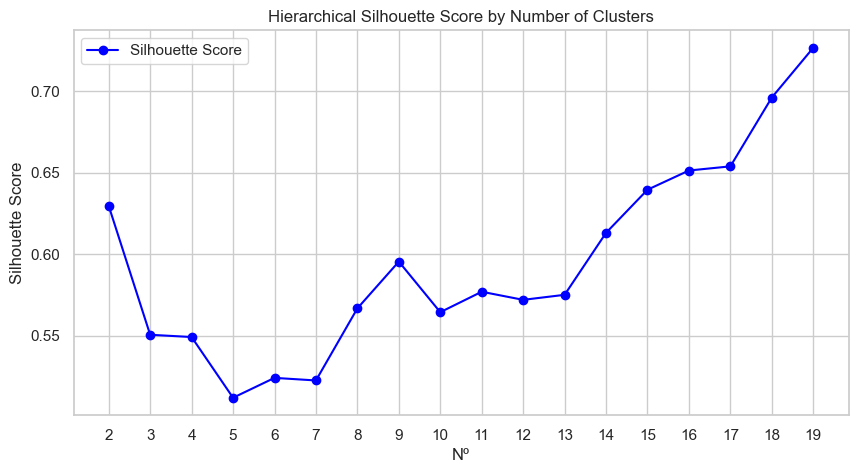

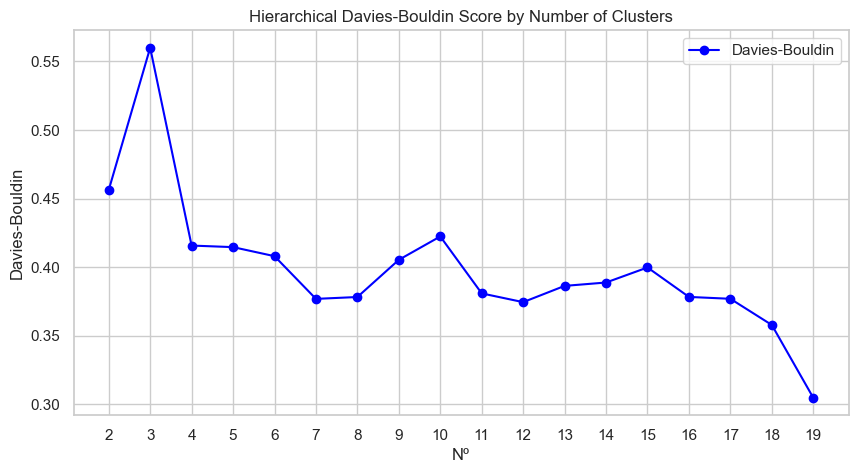

In [89]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(normalized_data, data_clusters))
    db.append(davies_bouldin_score(normalized_data, data_clusters))
    
    
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)

In [90]:
data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':4,'linkage':"complete"},fit=True)
df_cluster = pd.concat([predictive_processing_dataset["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]
name_output = f"Dif_Happy.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output)
    
    
    
output_name = f'test_distribution_4_clusters.xlsx'
utils.export_clusters_df(df_cluster.copy(),output_name)

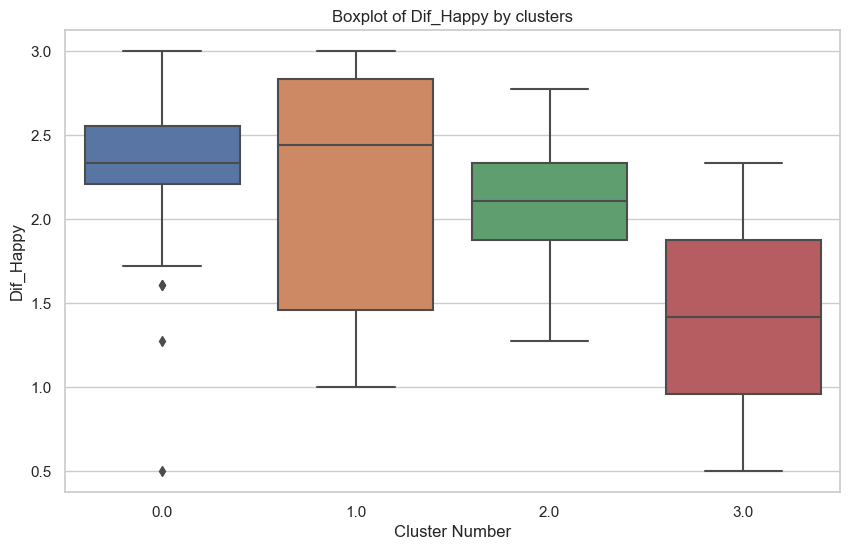

In [91]:
new_data = pd.merge(predictive_processing_dataset[significant_features + ["Subject"]].copy(), df_cluster.copy(), right_on='Subject', left_on='Subject')

cluster_column = 'clusters'  # Change this if the actual name differs
features = new_data.columns.drop([cluster_column,"Subject"])  # This excludes the cluster column from the features list

# Plotting
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cluster_column, y=feature, data=new_data)
    plt.title(f'Boxplot of {feature} by {cluster_column}')
    plt.xlabel('Cluster Number')
    plt.ylabel(feature)
    plt.show()

#### Feature that appears across more metrics

In [92]:
significant_features = ["Final_Value_Match_Negative"]


In [93]:
scaler = StandardScaler()
scaler.fit(predictive_processing_dataset[significant_features])
normalized_data = scaler.transform(predictive_processing_dataset[significant_features])


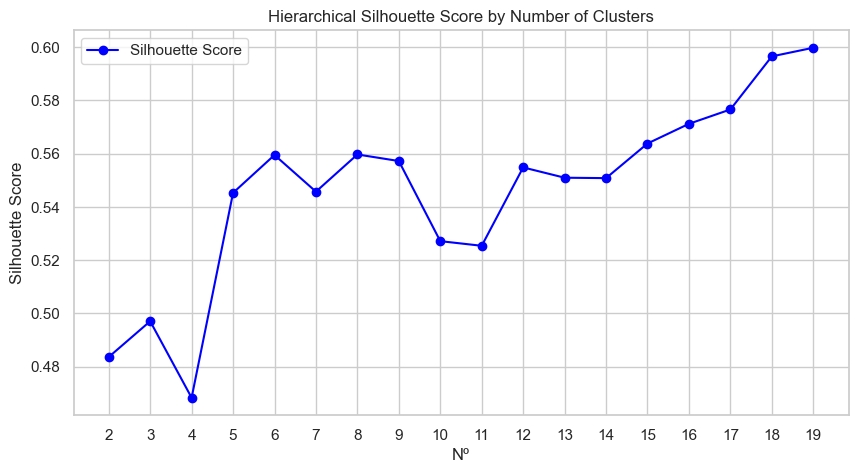

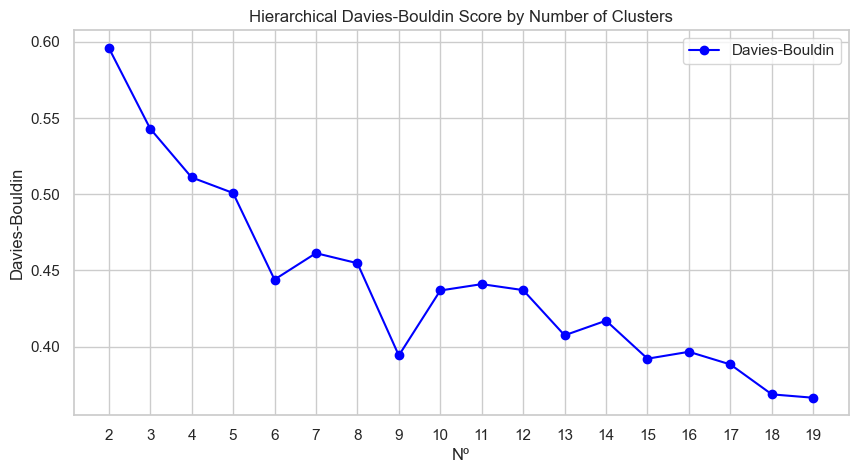

In [94]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(normalized_data, data_clusters))
    db.append(davies_bouldin_score(normalized_data, data_clusters))
    
    
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)

In [95]:
data_clusters = predictive_clustering.clustering(normalized_data,AgglomerativeClustering,{'n_clusters':6,'linkage':"complete"},fit=True)
df_cluster = pd.concat([predictive_processing_dataset["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]
name_output = f"Final_Match_Negative.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output)
    
    
    
output_name = f'test_distribution_4_clusters.xlsx'
utils.export_clusters_df(df_cluster.copy(),output_name)

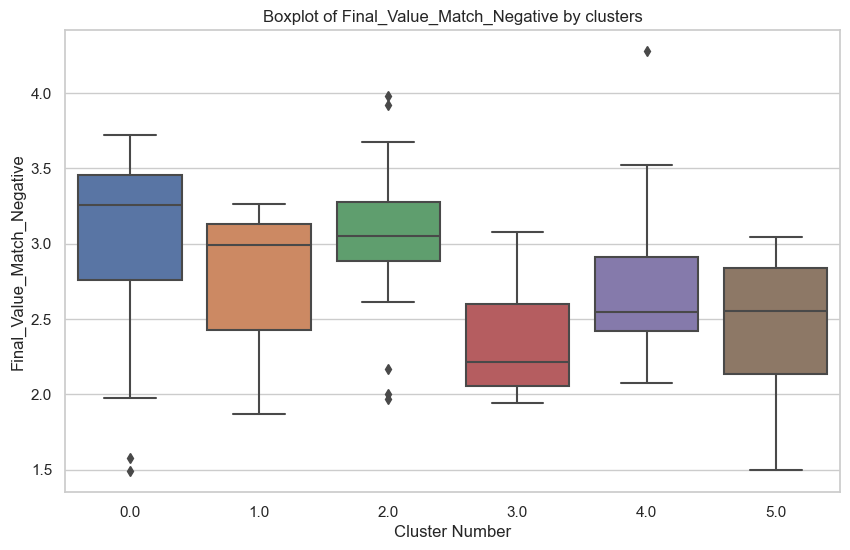

In [96]:
new_data = pd.merge(predictive_processing_dataset[significant_features + ["Subject"]].copy(), df_cluster.copy(), right_on='Subject', left_on='Subject')

cluster_column = 'clusters'  # Change this if the actual name differs
features = new_data.columns.drop([cluster_column,"Subject"])  # This excludes the cluster column from the features list

# Plotting
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cluster_column, y=feature, data=new_data)
    plt.title(f'Boxplot of {feature} by {cluster_column}')
    plt.xlabel('Cluster Number')
    plt.ylabel(feature)
    plt.show()